# Simulations

In [20]:
### Import Packages ###
import os
import numpy as np
import pandas as pd
import math as math
import random as random
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from treeFarms.treefarms.model.treefarms import TREEFARMS

### Local Packages ###
from utils.Auxiliary import *

# Input #
DataFile = "BreastCancer"
rashomon_bound_adder = 0.04
regularization = 0.01
TestProportion = 0.2
CandidateProportion = 0.8 
Seed = 0

# Load Data #
df = LoadData(DataFile)
random.seed(Seed)
np.random.seed(Seed)

# TreeFarms #
config = {"regularization": regularization, "rashomon_bound_adder": rashomon_bound_adder}
TreeFarmsModel = TREEFARMS(config)
TreeFarmsModel.fit(df.loc[:, df.columns != "Y"], df["Y"])
TreeCount = TreeFarmsModel.get_tree_count()

nulltreefarms reported successful execution

Finding Optimal Objective...
{
  "false": {
    "false": {
      "false": {
        "complexity": 0.009999999776482582,
        "loss": 0.03500000014901161,
        "name": "Y",
        "prediction": 1
      },
      "feature": 1,
      "name": "CellSize_1",
      "reference": 1,
      "relation": "==",
      "true": {
        "complexity": 0.009999999776482582,
        "loss": 0.009999999776482582,
        "name": "Y",
        "prediction": 0
      },
      "type": "integral"
    },
    "feature": 6,
    "name": "BareNuclei_1",
    "reference": 1,
    "relation": "==",
    "true": {
      "complexity": 0.009999999776482582,
      "loss": 0.004999999888241291,
      "name": "Y",
      "prediction": 0
    },
    "type": "integral"
  },
  "feature": 9,
  "model_objective": 0.09000000357627869,
  "name": "NormalNucleoli_10",
  "reference": 1,
  "relation": "==",
  "true": {
    "complexity": 0.009999999776482582,
    "loss": 0.0,
    "name": "Y

In [21]:
print("TreeCount: " + str(TreeCount))
print("Difference from 300k: " + str(TreeCount- 300000))
print("Difference from 500k: " + str(TreeCount- 500000))


TreeCount: 638089
Difference from 300k: 338089
Difference from 500k: 138089


In [ ]:

# Train Test Candidate Split #
from utils.Main import TrainTestCandidateSplit
df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, TestProportion, CandidateProportion)

### TRAIN TREEFARMS ###
# TreeFarms #
config = {"regularization": regularization, "rashomon_bound_adder": rashomon_bound_adder}
TreeFarmsModel = TREEFARMS(config)
TreeFarmsModel.fit(df_Train.loc[:, df_Train.columns != "Y"], df_Train["Y"])
TreeCount = TreeFarmsModel.get_tree_count()

In [11]:
print("TreeCount: " + str(TreeCount))
print("Difference from 300k: " + str(TreeCount- 300000))
print("Difference from 500k: " + str(TreeCount- 500000))


TreeCount: 12
Difference from 300k: -299988
Difference from 500k: -499988


## Prune

In [ ]:
# Duplicate and Unique #
PredictionArray_Duplicate = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Train.loc[:, df_Train.columns != "Y"]) for i in range(TreeCount)]))
PredictionArray_Unique = pd.DataFrame(PredictionArray_Duplicate).drop_duplicates(keep='first', ignore_index=False)
TrueValues = df_Train["Y"].to_numpy()
PredictionArray = PredictionArray_Unique

## Training Accuracy

In [ ]:
### TRAINING ACCURACY ###
# Training Accuracy #
TreeClassificationAccuracy = PredictionArray.eq(TrueValues, axis=1).mean(axis=1)
BestAccuracy = float(np.max(TreeClassificationAccuracy))

# Threshold Values #
EpsilonVec = BestAccuracy - TreeClassificationAccuracy
MinEpsilon = float(np.min(EpsilonVec))
MaxEpsilon = float(np.max(EpsilonVec))
ThresholdValues = np.linspace(MinEpsilon, MaxEpsilon, 1000)


## Test Accuracy

In [ ]:

### TEST ACCURACY ###
# Set Up #
ModelIndicesVec = []
Epsilon_F1Score = []
Epsilon_ClassAccuracy = []
for Threshold in ThresholdValues:

    # Filter Models Based on Threshold
    ModelIndices = EpsilonVec[EpsilonVec <= Threshold].index.tolist()
    Test_Predictions = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Test.loc[:, df_Test.columns != "Y"]) for i in ModelIndices]))
    Test_Predictions.columns = df_Test.index.astype(str)

    # Compute Ensemble Prediction (Mode)
    EnsemblePrediction = pd.Series(stats.mode(Test_Predictions, axis=0, keepdims=True)[0].flatten())
    EnsemblePrediction.index = df_Test["Y"].index

    # Compute Metrics
    F1Score = float(f1_score(df_Test["Y"], EnsemblePrediction, average='micro'))
    ClassAccuracy = float(np.mean(EnsemblePrediction == df_Test["Y"]))

    # Append Metrics
    ModelIndicesVec.append(ModelIndices)
    Epsilon_F1Score.append(F1Score)
    Epsilon_ClassAccuracy.append(ClassAccuracy)

# Analyze

In [2]:
### Input ###
Dataset = "Iris"
Directory = "/Users/simondn/Documents/RashomonActiveLearning/Results/OptimalThreshold/"

### All values ###
ThresholdValuesALL = pd.read_csv(os.path.join(Directory,Dataset,"Processed/ThresholdValuesStorage.csv"))
Epsilon_F1ScoreALL = pd.read_csv(os.path.join(Directory,Dataset,"Processed/Epsilon_F1ScoreStorage.csv"))
Epsilon_ClassAccuracyALL = pd.read_csv(os.path.join(Directory,Dataset,"Processed/Epsilon_ClassAccuracyStorage.csv"))

### Average Values ###
ThresholdValues_Mean = np.mean(ThresholdValuesALL, axis =0)
Epsilon_F1Score_Mean = np.mean(Epsilon_F1ScoreALL, axis =0)
Epsilon_ClassAccuracy_Mean = np.mean(Epsilon_ClassAccuracyALL, axis =0)

# Accuracy by Rashomon Threshold

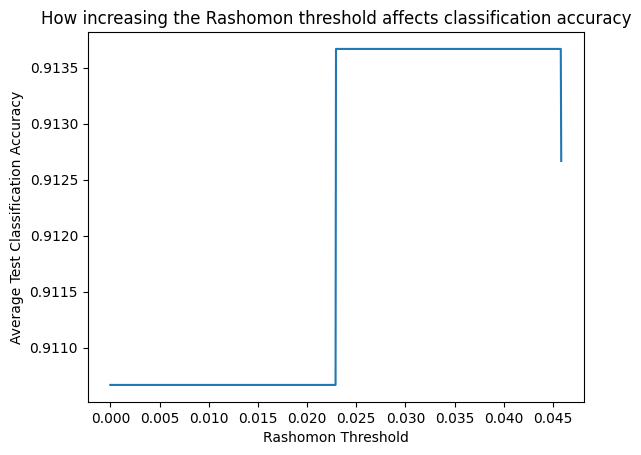

In [9]:
### Plot Accuracy ###
plt.plot(ThresholdValues_Mean, Epsilon_ClassAccuracy_Mean, label="Average Classification Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test Classification Accuracy")
plt.title("How increasing the Rashomon threshold affects classification accuracy")
plt.xticks(np.arange(0, 0.05, 0.005)) 
plt.show()

# F1 by Rashomon Threshold

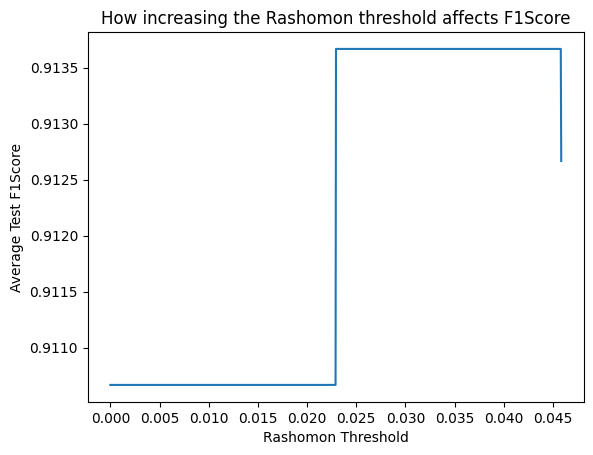

In [11]:
plt.plot(ThresholdValues_Mean, Epsilon_F1Score_Mean, label="Average F1 Score Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test F1Score")
plt.title("How increasing the Rashomon threshold affects F1Score")
plt.xticks(np.arange(0, 0.05, 0.005)) 
plt.show()